In [1]:
import glob
import h5py
import matplotlib.pyplot as plt 
import numpy as np 
import os
import pickle
import random

from omegaconf import OmegaConf
from holobot.robot.allegro.allegro_kdl import AllegroKDL
from tactile_learning.utils.visualization import plot_tactile_sensor

In [2]:
# Script to get random tactile information and the fingertip positions and
# visualize them

class KNNVisualizer:
    def __init__(
        self,
        data_path,
        sensor_indices = (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14),
        allegro_finger_indices = (0,1,2,3)
    ):
        self.data_path = data_path

        self.sensor_indices = sensor_indices 
        self.allegro_finger_indices = [j for i in allegro_finger_indices for j in range(i*3,(i+1)*3)]

        # Get the data
        self._load_data()

        self.idx = 2000

    def _load_data(self):
        roots = glob.glob(f'{self.data_path}/demonstration_*')
        roots = sorted(roots)

        self.tactile_indices = [] 
        self.allegro_indices = []
        self.kinova_indices = []
        self.tactile_values = []
        self.kinova_states = []
        self.allegro_tip_positions = [] 
        self.tactile_timestamps = []
        self.allegro_timestamps = []

        for root in roots:
            # Load the indices
            with open(os.path.join(root, 'tactile_indices.pkl'), 'rb') as f:
                self.tactile_indices += pickle.load(f)
            with open(os.path.join(root, 'allegro_indices.pkl'), 'rb') as f:
                self.allegro_indices += pickle.load(f)
            with open(os.path.join(root, 'kinova_indices.pkl'), 'rb') as f:
                self.kinova_indices += pickle.load(f)

            # Load the data
            with h5py.File(os.path.join(root, 'allegro_fingertip_states.h5'), 'r') as f:
                self.allegro_tip_positions.append(f['positions'][()][:, self.allegro_finger_indices])
                self.allegro_timestamps.append(f['timestamps'][()])
            with h5py.File(os.path.join(root, 'touch_sensor_values.h5'), 'r') as f:
                self.tactile_values.append(f['sensor_values'][()][:,self.sensor_indices,:,:])
                self.tactile_timestamps.append(f['timestamps'][()])
            with h5py.File(os.path.join(root, 'kinova_cartesian_states.h5'), 'r') as f:
                self.kinova_states.append(f['positions'][()])


        assert len(self.tactile_indices) == len(self.allegro_indices)

    # Method to create a random index and return random allegro
    # fingertip position and a tactile sensor
    def get_example_state(self):
        # Also we will be checking the timestamps as well

        # Get random index
        rand_idx = random.randrange(0, len(self.tactile_indices))

        # Get random tactile value
        demo_id, tactile_id = self.tactile_indices[rand_idx]
        tactile_value = self.tactile_values[demo_id][tactile_id]
        tactile_timestamp = self.tactile_timestamps[demo_id][tactile_id]

        print('tactile_value.shape: {}, tactile_timestamp: {}'.format(
            tactile_value.shape, tactile_timestamp
        ))

        # Get random allegro tip position
        demo_id, allegro_id = self.allegro_indices[rand_idx]
        allegro_tip_pos = self.allegro_tip_positions[demo_id][allegro_id]
        allegro_timestamp = self.allegro_timestamps[demo_id][allegro_id]

        print('allegro_tip_pos.shape: {}, allegro_timestamp: {}'.format(
            allegro_tip_pos.shape, allegro_timestamp
        ))

        demo_id, kinova_id = self.kinova_indices[rand_idx]
        kinova_cart_pos = self.kinova_states[demo_id][kinova_id]

        return tactile_value, allegro_tip_pos, kinova_cart_pos

    def get_ordered_state(self):
        if self.idx >= len(self.tactile_indices):
            self.idx = 2000
        
        self.idx += 20
        
        demo_id, tactile_id = self.tactile_indices[self.idx]
        tactile_value = self.tactile_values[demo_id][tactile_id]
        tactile_timestamp = self.tactile_timestamps[demo_id][tactile_id]

        print('tactile_value.shape: {}, tactile_timestamp: {} [{},{}]'.format(
            tactile_value.shape, tactile_timestamp, demo_id, tactile_id
        ))

        # Get random allegro tip position
        demo_id, allegro_id = self.allegro_indices[self.idx]
        allegro_tip_pos = self.allegro_tip_positions[demo_id][allegro_id]
        allegro_timestamp = self.allegro_timestamps[demo_id][allegro_id]

        demo_id, kinova_id = self.kinova_indices[rand_idx]
        kinova_cart_pos = self.kinova_states[demo_id][kinova_id]

        print('allegro_tip_pos.shape: {}, allegro_timestamp: {} [{},{}]'.format(
            allegro_tip_pos.shape, allegro_timestamp, demo_id, allegro_id
        ))

        return tactile_value, allegro_tip_pos, kinova_cart_pos

    


In [3]:
knn_visualizer = KNNVisualizer(
    data_path='/home/irmak/Workspace/Holo-Bot/extracted_data/box_handle_lifting'
)

In [42]:
tactile_value, allegro_tip_pos, kinova_cart_pos = knn_visualizer.get_example_state()

tactile_value.shape: (15, 16, 3), tactile_timestamp: 1672689469.617531
allegro_tip_pos.shape: (12,), allegro_timestamp: 1672689469.615647


In [21]:
def plot_xyz_position(ax, position, title, color='blue', ylims=None):
    types = ['X', 'Y', 'Z']
    if ylims is None:
        ax.set_ylim(-0.05, 0.15)
    else:
        ax.set_ylim(ylims)
    ax.bar(types, position, color=color)
    ax.set_title(title)

def plot_fingertip_position(ax, tip_position, finger_index): 
    # Tip position: (3,) - (x,y,z) positions of the tip
    # finger_index: 0 or 1
    types = ['X', 'Y', 'Z']
    values = tip_position 

    ax.set_ylim(-0.05, 0.15)
    if finger_index == 0: # The index finger 
        ax.bar(types, values, color='darkolivegreen')
        ax.set_title('Index Finger Tip Position')
    elif finger_index == 1:
        ax.bar(types, values, color='mediumturquoise')
        ax.set_title('Middle Finger Tip Position')
    
    

In [75]:
def dump_tactile_state(tactile_values):
    fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(10,10))
    for col_id in range(4):
        for row_id in range(4):
            if col_id + row_id > 0:
                plot_tactile_sensor(
                    ax = axs[row_id, col_id],
                    sensor_values = tactile_values[col_id*4+row_id-1],
                    title=f'Finger: {col_id}, Sensor: {row_id}'
                )
            axs[row_id, col_id].get_yaxis().set_ticks([])
            axs[row_id, col_id].get_xaxis().set_ticks([])
    fig.savefig('tactile_state.png', bbox_inches='tight')
    fig.clf()
    plt.close()

def dump_robot_state(allegro_tip_pos, kinova_cart_pos):
    fig = plt.figure(figsize=(10,10))
    allegro_axs = []
    for i in range(2):
        for j in range(2):
            allegro_axs.append(
                plt.subplot2grid((2,4), (i,j), fig=fig)
            )
    kinova_ax = plt.subplot2grid((2,4), (0,2), colspan=2, rowspan=2, fig=fig)
    for i,ax in enumerate(allegro_axs):
        plot_xyz_position(ax = ax, position = allegro_tip_pos[i*3:(i+1)*3], title=f'Finger {i}', color='mediumturquoise', ylims=(-0.1,0.2))
        ax.get_yaxis().set_ticks([])
    plot_xyz_position(ax = kinova_ax, position = kinova_cart_pos, title=f'Arm Wrist Position', color = 'darkolivegreen', ylims=(-0.75,0.75))
    kinova_ax.get_yaxis().set_ticks([])
    plt.savefig('robot_state.png', bbox_inches='tight')
    plt.close()

import cv2

def dump_whole_state(tactile_values, allegro_tip_pos, kinova_cart_pos, title='curr_state'):
    dump_tactile_state(tactile_values)
    dump_robot_state(allegro_tip_pos, kinova_cart_pos)
    tactile_state = cv2.imread('tactile_state.png')
    robot_state = cv2.imread('robot_state.png')
    state_img = concat_imgs(tactile_state, robot_state, orientation='horizontal')
    cv2.imwrite(f'{title}.png', state_img)

def concat_imgs(img1, img2, orientation='horizontal'): # Or it could be vertical as well
    metric_id = 0 if orientation == 'horizontal' else 1
    max_metric = max(img1.shape[metric_id], img2.shape[metric_id])
    min_metric = min(img1.shape[metric_id], img2.shape[metric_id])
    scale = min_metric / max_metric
    large_img_idx = np.argmax([img1.shape[metric_id], img2.shape[metric_id]])

    if large_img_idx == 0: 
        img1 = cv2.resize(
            img1, 
            (int(img1.shape[1]*scale),
             int(img1.shape[0]*scale))
        )
    else: 
        img2 = cv2.resize(
            img2, 
            (int(img2.shape[1]*scale),
             int(img2.shape[0]*scale))
        )

    concat_img = cv2.hconcat([img1, img2]) if orientation == 'horizontal' else cv2.vconcat([img1, img2])
    return concat_img


tactile_value.shape: (2, 16, 3), tactile_timestamp: 1670206041.8915246 [4,491]
allegro_tip_pos.shape: (6,), allegro_timestamp: 1670206041.8941538 [4,1855]


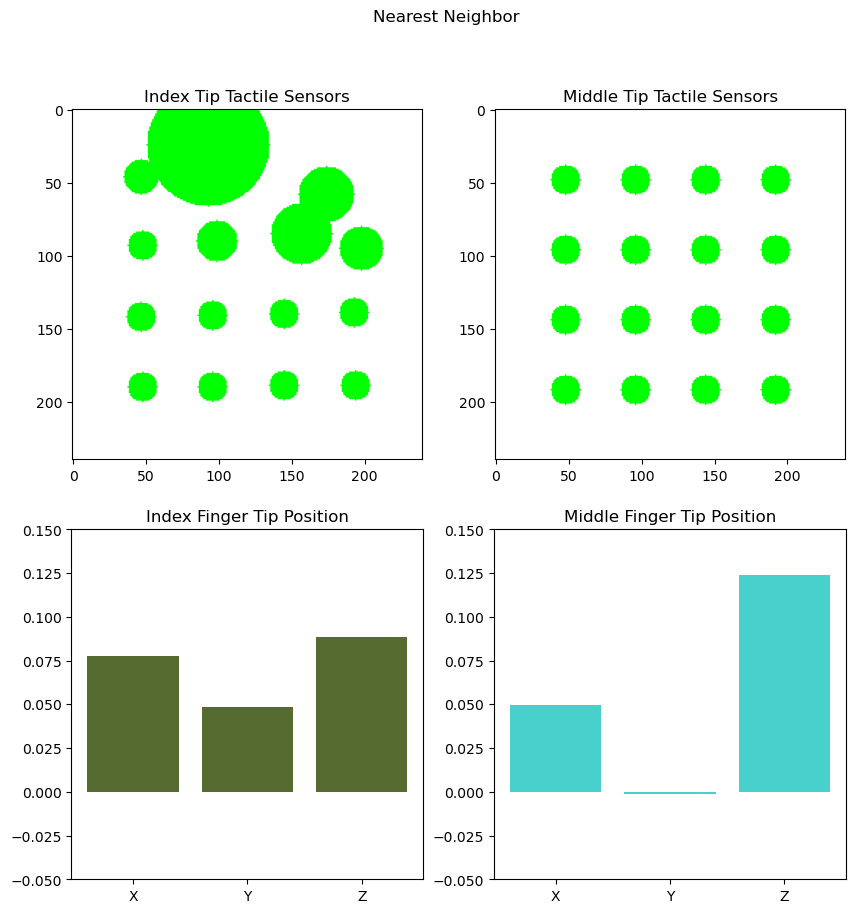

In [202]:
tactile_value, allegro_tip_pos = knn_visualizer.get_ordered_state()
fig, _ = dump_tactile_state(tactile_value, allegro_tip_pos)     

In [76]:
# Script to look at the current image
from holobot.constants import CAM_FPS, DEPTH_RECORD_FPS, IMAGE_RECORD_RESOLUTION
from holobot.utils.files import store_pickle_data
from holobot.utils.network import ZMQCameraSubscriber

In [77]:
import cv2

def dump_camera_image(host, image_stream_port):
    image_subscriber = ZMQCameraSubscriber(
        host = host,
        port = image_stream_port,
        topic_type = 'RGB'
    )
    image, timestamp = image_subscriber.recv_rgb_image()
    cv2.imwrite('camera_image.png', image)

# Camera offsets
host = '172.24.71.240'
image_stream_port = 10005
dump_camera_image(host, image_stream_port)

In [79]:
# Get two random tactile positions and tip positions and dump them
curr_tactile_value, curr_tip_pos, curr_car_pos = knn_visualizer.get_example_state()
knn_tactile_value, knn_tip_pos, knn_car_pos = knn_visualizer.get_example_state()

tactile_value.shape: (15, 16, 3), tactile_timestamp: 1672693344.653021
allegro_tip_pos.shape: (12,), allegro_timestamp: 1672693344.6487105
tactile_value.shape: (15, 16, 3), tactile_timestamp: 1672679967.6670985
allegro_tip_pos.shape: (12,), allegro_timestamp: 1672679967.659077


In [80]:
dump_whole_state(curr_tactile_value, curr_tip_pos, curr_car_pos, title='curr_state')
dump_whole_state(knn_tactile_value, knn_tip_pos, knn_car_pos, title='knn_state')

In [15]:
# Dump the current state
dump_tactile_state(curr_tactile_value, curr_tip_pos, title='Current State')
fig, _ = dump_tactile_state(knn_tactile_value, knn_tip_pos, title='Nearest Neighbor')
dump_camera_image(host, image_stream_port)

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

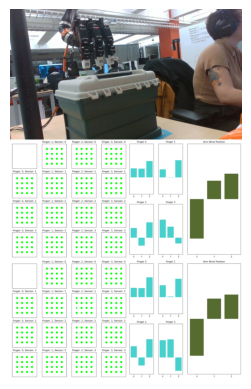

In [82]:
# def plot_all
def plot_knn_state():
    camera_img = cv2.imread('camera_image.png')
    knn_state = cv2.imread('knn_state.png')
    curr_state = cv2.imread('curr_state.png')

    state_img = concat_imgs(curr_state, knn_state, 'vertical')
    all_state_img = concat_imgs(camera_img, state_img, 'vertical')
    plt.axis('off')
    plt.imshow(cv2.cvtColor(all_state_img, cv2.COLOR_BGR2RGB))

# Read all of them and horizontally stack them
# def plot_knn_state():
#     curr_state = cv2.imread('Current State.png')
#     knn_state = cv2.imread('Nearest Neighbor.png')
#     camera_img = cv2.imread('Camera Image.png')

#     state_img = cv2.hconcat([curr_state, knn_state])
#     width_scale = camera_img.shape[1] / state_img.shape[1]
#     state_img = cv2.resize(
#         state_img, 
#         (int(state_img.shape[1] * width_scale),
#          int(state_img.shape[0] * width_scale))
#     )

#     all_state_img = cv2.vconcat([camera_img, state_img])
#     plt.axis('off')
#     plt.imshow(cv2.cvtColor(all_state_img, cv2.COLOR_BGR2RGB))

    


    


# curr_state = cv2.imread('Current State.png')
# knn_state = cv2.imread('Nearest Neighbor.png')
# camera_img = cv2.imread('Camera Image.png')
# print('curr_state.shape: {}, knn_state.shape: {}'.format(
#     curr_state.shape, knn_state.shape
# ))
# new_img = cv2.hconcat([curr_state, knn_state])
# width_scale = float(camera_img.shape[1] / (curr_state.shape[1] + knn_state.shape[1]))
# new_width = int(new_img.shape[1] * width_scale)
# new_height = int(new_img.shape[0] * width_scale)
# new_img = cv2.resize(new_img, (new_width, new_height))

# plt.axis('off')
# plt.imshow(cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB))
# print('new_img.shape: {}, camera_img.shape: {}'.format(
#     new_img.shape, camera_img.shape
# ))
# new_img_2 = cv2.vconcat([camera_img, new_img])
# plt.imshow(cv2.cvtColor(new_img_2, cv2.COLOR_BGR2RGB))

# plt.pause(0.001) # This make the graph show up if matplotlib is in Tkinter mode
# plt.cla()

plot_knn_state()

In [8]:
from PIL import Image as im 
import torch
import cv2
import numpy as np
import torchvision.transforms as T
from tactile_learning.utils.augmentations import crop_transform
from tactile_learning.utils.constants import *
from holobot.utils.network import ZMQCameraSubscriber

image_transform = T.Compose([
    T.Resize((480,640)),
    T.Lambda(crop_transform),
    T.ToTensor(),
    T.Normalize(VISION_IMAGE_MEANS, VISION_IMAGE_STDS),
]) 

np_means = np.asarray(VISION_IMAGE_MEANS)
np_stds = np.asarray(VISION_IMAGE_STDS)

inv_normalization_transform = T.Compose([
    T.Normalize(mean = [0,0,0], std = 1 / np_stds ), 
    T.Normalize(mean = -np_means, std = [1,1,1])
])


def get_curr_image(host='172.24.71.240', port=10005):
    image_subscriber = ZMQCameraSubscriber(
        host = host,
        port = port,
        topic_type = 'RGB'
    )
    image, _ = image_subscriber.recv_rgb_image()
    print('get_curr_image.shape: {}'.format(image.shape))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = im.fromarray(image)
    img = image_transform(image)
    return torch.FloatTensor(img)

# def _load_dataset_image(demo_id, image_id):
#     roots = glob.glob(f'{self.image_cfg.data_dir}/demonstration_*')
#     roots = sorted(roots)
#     image_root = roots[demo_id]
#     image_path = os.path.join(image_root, 'cam_0_rgb_images/frame_{}.png'.format(str(image_id).zfill(5)))
#     img = self.image_transform(loader(image_path))
#     return torch.FloatTensor(img)


In [14]:
curr_img = inv_normalization_transform(get_curr_image()).numpy().transpose(1,2,0)


get_curr_image.shape: (720, 1280, 3)


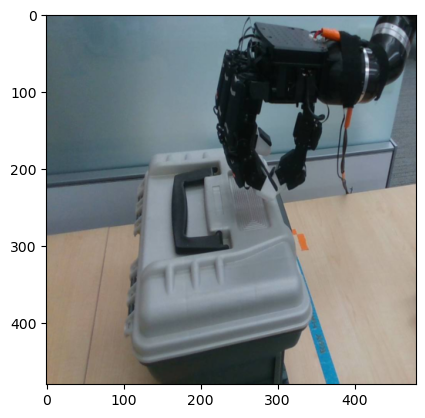

In [15]:
import matplotlib.pyplot as plt 
plt.imshow(curr_img)

In [19]:
cv2_img = cv2.cvtColor(curr_img*255, cv2.COLOR_RGB2BGR)
cv2.imwrite('curr_img.png', cv2_img)

True